In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v6 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-11 18:45:52.973434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-11 18:45:52.973692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:45:53.016893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:45:53.017208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:45:53.017500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 18:45:53.017740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '005'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

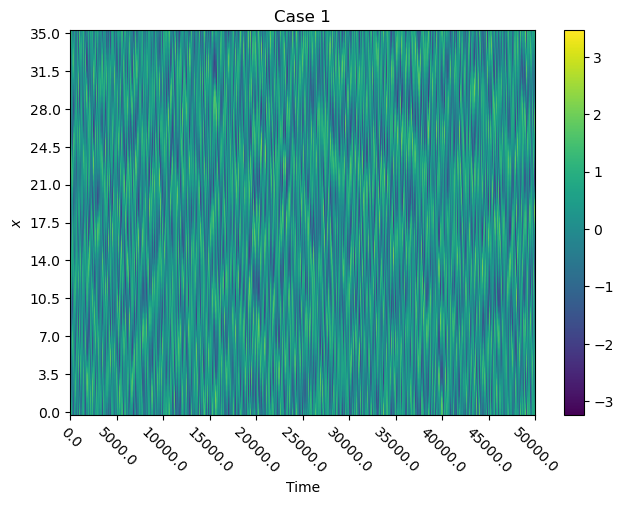

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=FTYPE)
        if normalization_type == 'stddev':
            for i in range(numpoints_xgrid):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                normalization_constant_arr_aedata[0, i] = sample_mean
                normalization_constant_arr_aedata[1, i] = stddev_multiplier*sample_std
        elif normalization_type == 'minmax':
            for i in range(numpoints_xgrid):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
    time_stddev = time_stddev[0:numpoints_xgrid]
else:
    time_stddev[numpoints_xgrid:] = 1.0

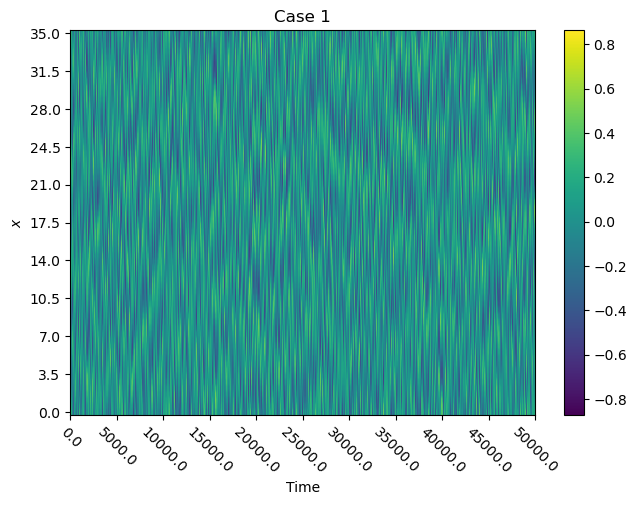

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

# Autoencoder

In [18]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 256
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:numpoints_xgrid])
    contractive_lmda = 5e-3
    use_weights_post_dense = False
    dropout_rate = 0.0
    

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'contractive_lmda':contractive_lmda,
        'dropout_rate':dropout_rate,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        contractive_lmda = tparams_dict['contractive_lmda']
    except:
        print("'contractive_lmda' not in tparams_dict, set to 0")
        contractive_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [19]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [20]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [21]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 48
    enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
    # enc_layers = [32, 16, 8, 4]
    for i in range(len(enc_layers)):
        if latent_space_dim < enc_layers[-i-1]:
            enc_layers = enc_layers[0:-i]
            break
        if i == len(enc_layers)-1:
            enc_layers = []
    dec_layers = enc_layers[::-1]
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                contractive_lmda=contractive_lmda,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            contractive_lmda=contractive_lmda,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [23]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

train_ls_jacobian_norm_hist = []

In [24]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        train_ls_jacobian_norm_hist.append(history.history['ls_jacobian_norm'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
1561/1563 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 0.0022 - NMSE: 0.0200 - ls_jacobian_norm: 0.5244 - tot_time: 0h 0m 24.9s

Epoch 1: val_NMSE improved from inf to 0.00624, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0026 - mse: 0.0022 - NMSE: 0.0200 - ls_jacobian_norm: 0.5237 - val_loss: 0.0011 - val_mse: 6.9320e-04 - val_NMSE: 0.0062 - val_ls_jacobian_norm: -1.0000
Epoch 2/1000
1561/1563 [============================>.] - ETA: 0s - loss: 9.7997e-04 - mse: 5.5062e-04

Epoch 14/1000
1561/1563 [============================>.] - ETA: 0s - loss: 6.8410e-04 - mse: 2.5755e-04 - NMSE: 0.0023 - ls_jacobian_norm: 0.0520 - tot_time: 0h 5m 18.7s

Epoch 14: val_NMSE improved from 0.00257 to 0.00242, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 14ms/step - loss: 6.8411e-04 - mse: 2.5757e-04 - NMSE: 0.0023 - ls_jacobian_norm: 0.0520 - val_loss: 6.9404e-04 - val_mse: 2.6869e-04 - val_NMSE: 0.0024 - val_ls_jacobian_norm: -1.0000
Epoch 15/1000
1560/1563 [============================>.] - ETA: 0s - loss: 6.7415e-04 - mse: 2.4996e-04 - NMSE: 0.0023 - ls_jacobian_norm: 0.0516 - tot_time: 0h 5m 41.4s

Epoch 15: val_NMSE improved from 0.00242 to 0.00230, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - sa

1561/1563 [============================>.] - ETA: 0s - loss: 6.0970e-04 - mse: 2.0370e-04 - NMSE: 0.0018 - ls_jacobian_norm: 0.0489 - tot_time: 0h 10m 13.1s

Epoch 27: val_NMSE improved from 0.00177 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 6.0968e-04 - mse: 2.0368e-04 - NMSE: 0.0018 - ls_jacobian_norm: 0.0489 - val_loss: 5.9904e-04 - val_mse: 1.9342e-04 - val_NMSE: 0.0017 - val_ls_jacobian_norm: -1.0000
Epoch 28/1000
1562/1563 [============================>.] - ETA: 0s - loss: 6.0755e-04 - mse: 2.0251e-04 - NMSE: 0.0018 - ls_jacobian_norm: 0.0489 - tot_time: 0h 10m 36.1s

Epoch 28: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoi

Epoch 41/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.8809e-04 - mse: 1.8397e-04 - NMSE: 0.0017 - ls_jacobian_norm: 0.0476 - tot_time: 0h 15m 32.6s

Epoch 41: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.8810e-04 - mse: 1.8398e-04 - NMSE: 0.0017 - ls_jacobian_norm: 0.0476 - val_loss: 5.8895e-04 - val_mse: 1.8540e-04 - val_NMSE: 0.0017 - val_ls_jacobian_norm: -1.0000
Epoch 42/1000
1560/1563 [============================>.] - ETA: 0s - loss: 7.0390e-04 - mse: 3.1215e-04 - NMSE: 0.0028 - ls_jacobian_norm: 0.0547 - tot_time: 0h 15m 55.5s

Epoch 42: val_NMSE improved from 0.00139 to 0.00135, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHis

Epoch 55/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.7722e-04 - mse: 1.7094e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0465 - tot_time: 0h 20m 52.9s

Epoch 55: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.7722e-04 - mse: 1.7093e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0465 - val_loss: 5.7791e-04 - val_mse: 1.7141e-04 - val_NMSE: 0.0015 - val_ls_jacobian_norm: -1.0000
Epoch 56/1000
1559/1563 [============================>.] - ETA: 0s - loss: 5.7600e-04 - mse: 1.6942e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0464 - tot_time: 0h 21m 15.7s

Epoch 56: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.7601e-04 - mse:

1563/1563 [==============================] - ETA: 0s - loss: 5.7127e-04 - mse: 1.6365e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0461 - tot_time: 0h 26m 12.3s

Epoch 69: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.7127e-04 - mse: 1.6365e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0461 - val_loss: 5.6129e-04 - val_mse: 1.5350e-04 - val_NMSE: 0.0014 - val_ls_jacobian_norm: -1.0000
Epoch 70/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.7092e-04 - mse: 1.6306e-04 - NMSE: 0.0015 - ls_jacobian_norm: 0.0460 - tot_time: 0h 26m 35.1s

Epoch 70: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.7092e-04 - mse: 1.6306e-04 - 

1560/1563 [============================>.] - ETA: 0s - loss: 5.6492e-04 - mse: 1.5688e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0460 - tot_time: 0h 31m 31.0s

Epoch 83: val_NMSE did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 14ms/step - loss: 5.6492e-04 - mse: 1.5688e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0460 - val_loss: 5.6407e-04 - val_mse: 1.5548e-04 - val_NMSE: 0.0014 - val_ls_jacobian_norm: -1.0000
Epoch 84/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.6561e-04 - mse: 1.5708e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0458 - tot_time: 0h 31m 53.7s

Epoch 84: val_NMSE did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.6559e-04 - mse: 1.5706e-04 - 

1563/1563 [==============================] - ETA: 0s - loss: 5.6305e-04 - mse: 1.5370e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0455 - tot_time: 0h 36m 52.7s

Epoch 97: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.6305e-04 - mse: 1.5370e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0455 - val_loss: 5.6202e-04 - val_mse: 1.5309e-04 - val_NMSE: 0.0014 - val_ls_jacobian_norm: -1.0000
Epoch 98/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.6273e-04 - mse: 1.5355e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0455 - tot_time: 0h 37m 15.9s

Epoch 98: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.6275e-04 - mse: 1.5357e-04 - 

1562/1563 [============================>.] - ETA: 0s - loss: 5.6052e-04 - mse: 1.5047e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0453 - tot_time: 0h 42m 17.3s

Epoch 111: val_NMSE did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.6052e-04 - mse: 1.5047e-04 - NMSE: 0.0014 - ls_jacobian_norm: 0.0453 - val_loss: 5.4590e-04 - val_mse: 1.3608e-04 - val_NMSE: 0.0012 - val_ls_jacobian_norm: -1.0000
Epoch 112/1000
1562/1563 [============================>.] - ETA: 0s - loss: 6.1315e-04 - mse: 2.1679e-04 - NMSE: 0.0020 - ls_jacobian_norm: 0.0513 - tot_time: 0h 42m 40.5s

Epoch 112: val_NMSE improved from 0.00113 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheck

1561/1563 [============================>.] - ETA: 0s - loss: 5.5854e-04 - mse: 1.4781e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0452 - tot_time: 0h 47m 38.6s

Epoch 125: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5855e-04 - mse: 1.4782e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0452 - val_loss: 5.6363e-04 - val_mse: 1.5239e-04 - val_NMSE: 0.0014 - val_ls_jacobian_norm: -1.0000
Epoch 126/1000
1560/1563 [============================>.] - ETA: 0s - loss: 6.3551e-04 - mse: 2.2532e-04 - NMSE: 0.0020 - ls_jacobian_norm: 0.0458 - tot_time: 0h 48m 1.3s

Epoch 126: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 6.3638e-04 - mse: 2.2624e-04 

1560/1563 [============================>.] - ETA: 0s - loss: 5.5663e-04 - mse: 1.4550e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0451 - tot_time: 0h 52m 58.8s

Epoch 139: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5664e-04 - mse: 1.4551e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0451 - val_loss: 5.6024e-04 - val_mse: 1.4882e-04 - val_NMSE: 0.0013 - val_ls_jacobian_norm: -1.0000
Epoch 140/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.5667e-04 - mse: 1.4557e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0451 - tot_time: 0h 53m 21.6s

Epoch 140: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5667e-04 - mse: 1.4557e-04

1563/1563 [==============================] - ETA: 0s - loss: 5.5452e-04 - mse: 1.4287e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0450 - tot_time: 0h 58m 19.2s

Epoch 153: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5452e-04 - mse: 1.4287e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0450 - val_loss: 5.5473e-04 - val_mse: 1.4300e-04 - val_NMSE: 0.0013 - val_ls_jacobian_norm: -1.0000
Epoch 154/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.5419e-04 - mse: 1.4261e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0449 - tot_time: 0h 58m 42.1s

Epoch 154: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5418e-04 - mse: 1.4261e-04

1563/1563 [==============================] - ETA: 0s - loss: 5.5364e-04 - mse: 1.4162e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0449 - tot_time: 1h 3m 40.5s

Epoch 167: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5364e-04 - mse: 1.4162e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0449 - val_loss: 5.6422e-04 - val_mse: 1.5228e-04 - val_NMSE: 0.0014 - val_ls_jacobian_norm: -1.0000
Epoch 168/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.5359e-04 - mse: 1.4177e-04 - NMSE: 0.0013 - ls_jacobian_norm: 0.0449 - tot_time: 1h 4m 3.4s

Epoch 168: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.5359e-04 - mse: 1.4177e-04 - 

Epoch 1/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1278e-04 - mse: 1.0506e-04 - NMSE: 9.4565e-04 - ls_jacobian_norm: 0.0462 - tot_time: 1h 9m 1.1s

Epoch 1: val_NMSE improved from 0.00109 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1278e-04 - mse: 1.0506e-04 - NMSE: 9.4566e-04 - ls_jacobian_norm: 0.0462 - val_loss: 5.1022e-04 - val_mse: 9.8913e-05 - val_NMSE: 8.9036e-04 - val_ls_jacobian_norm: -1.0000
Epoch 2/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.1872e-04 - mse: 1.0403e-04 - NMSE: 9.3643e-04 - ls_jacobian_norm: 0.0444 - tot_time: 1h 9m 24.0s

Epoch 2: val_NMSE improved from 0.00089 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/check

Epoch 14/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.2758e-04 - mse: 9.7533e-05 - NMSE: 8.7794e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 13m 58.7s

Epoch 14: val_NMSE improved from 0.00083 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.2758e-04 - mse: 9.7531e-05 - NMSE: 8.7792e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.2066e-04 - val_mse: 9.0635e-05 - val_NMSE: 8.1584e-04 - val_ls_jacobian_norm: -1.0000
Epoch 15/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.2729e-04 - mse: 9.7312e-05 - NMSE: 8.7594e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 14m 21.7s

Epoch 15: val_NMSE did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/che

1560/1563 [============================>.] - ETA: 0s - loss: 5.2440e-04 - mse: 9.5445e-05 - NMSE: 8.5914e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 18m 56.5s

Epoch 27: val_NMSE did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.2440e-04 - mse: 9.5445e-05 - NMSE: 8.5914e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.1884e-04 - val_mse: 8.9945e-05 - val_NMSE: 8.0963e-04 - val_ls_jacobian_norm: -1.0000
Epoch 28/1000
1559/1563 [============================>.] - ETA: 0s - loss: 5.2403e-04 - mse: 9.5162e-05 - NMSE: 8.5659e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 19m 19.4s

Epoch 28: val_NMSE did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.2403e-04 - ms

Epoch 41/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.2161e-04 - mse: 9.3543e-05 - NMSE: 8.4202e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 24m 18.8s

Epoch 41: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.2161e-04 - mse: 9.3543e-05 - NMSE: 8.4202e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.1512e-04 - val_mse: 8.7089e-05 - val_NMSE: 7.8392e-04 - val_ls_jacobian_norm: -1.0000
Epoch 42/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.2135e-04 - mse: 9.3334e-05 - NMSE: 8.4014e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 24m 41.8s

Epoch 42: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5

Epoch 55/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1931e-04 - mse: 9.1910e-05 - NMSE: 8.2732e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 29m 43.1s

Epoch 55: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1931e-04 - mse: 9.1908e-05 - NMSE: 8.2730e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.1344e-04 - val_mse: 8.6056e-05 - val_NMSE: 7.7462e-04 - val_ls_jacobian_norm: -1.0000
Epoch 56/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1916e-04 - mse: 9.1786e-05 - NMSE: 8.2620e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 30m 6.3s

Epoch 56: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1762e-04 - mse: 9.0675e-05 - NMSE: 8.1620e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.1012e-04 - val_mse: 8.3201e-05 - val_NMSE: 7.4893e-04 - val_ls_jacobian_norm: -1.0000
Epoch 69/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1750e-04 - mse: 9.0590e-05 - NMSE: 8.1543e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 35m 7.2s

Epoch 69: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1750e-04 - mse: 9.0593e-05 - NMSE: 8.1546e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.1216e-04 - val_mse: 8.5273e-05 - val_NMSE: 7.6758e-04 - val_ls_jacobian_norm: -1.0000
Epoch 70/1000
1562/1563 [==========================

Epoch 82/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1611e-04 - mse: 8.9593e-05 - NMSE: 8.0646e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 40m 7.6s

Epoch 82: val_NMSE did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1611e-04 - mse: 8.9590e-05 - NMSE: 8.0644e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.0963e-04 - val_mse: 8.3125e-05 - val_NMSE: 7.4824e-04 - val_ls_jacobian_norm: -1.0000
Epoch 83/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1600e-04 - mse: 8.9512e-05 - NMSE: 8.0573e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 40m 30.5s

Epoch 83: val_NMSE did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.

Epoch 96/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1468e-04 - mse: 8.8540e-05 - NMSE: 7.9698e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 45m 30.8s

Epoch 96: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1468e-04 - mse: 8.8541e-05 - NMSE: 7.9700e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.0919e-04 - val_mse: 8.3054e-05 - val_NMSE: 7.4761e-04 - val_ls_jacobian_norm: -1.0000
Epoch 97/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.1467e-04 - mse: 8.8543e-05 - NMSE: 7.9701e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 45m 53.8s

Epoch 97: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5

Epoch 110/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.1361e-04 - mse: 8.7843e-05 - NMSE: 7.9071e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 50m 54.2s

Epoch 110: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1361e-04 - mse: 8.7843e-05 - NMSE: 7.9071e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.0768e-04 - val_mse: 8.1930e-05 - val_NMSE: 7.3748e-04 - val_ls_jacobian_norm: -1.0000
Epoch 111/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1347e-04 - mse: 8.7725e-05 - NMSE: 7.8964e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 51m 17.3s

Epoch 111: val_NMSE did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 124/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1260e-04 - mse: 8.7160e-05 - NMSE: 7.8456e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 56m 17.1s

Epoch 124: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1260e-04 - mse: 8.7163e-05 - NMSE: 7.8459e-04 - ls_jacobian_norm: 0.0406 - val_loss: 5.0555e-04 - val_mse: 8.0123e-05 - val_NMSE: 7.2122e-04 - val_ls_jacobian_norm: -1.0000
Epoch 125/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1260e-04 - mse: 8.7183e-05 - NMSE: 7.8477e-04 - ls_jacobian_norm: 0.0406 - tot_time: 1h 56m 40.3s

Epoch 125: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 138/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1180e-04 - mse: 8.6665e-05 - NMSE: 7.8011e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 1m 40.0s

Epoch 138: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1180e-04 - mse: 8.6666e-05 - NMSE: 7.8011e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0508e-04 - val_mse: 7.9943e-05 - val_NMSE: 7.1960e-04 - val_ls_jacobian_norm: -1.0000
Epoch 139/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.1183e-04 - mse: 8.6725e-05 - NMSE: 7.8065e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 2m 3.1s

Epoch 139: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 

Epoch 152/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1108e-04 - mse: 8.6218e-05 - NMSE: 7.7609e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 7m 4.2s

Epoch 152: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1108e-04 - mse: 8.6218e-05 - NMSE: 7.7608e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0483e-04 - val_mse: 7.9977e-05 - val_NMSE: 7.1991e-04 - val_ls_jacobian_norm: -1.0000
Epoch 153/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1114e-04 - mse: 8.6301e-05 - NMSE: 7.7683e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 7m 27.4s

Epoch 153: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 

Epoch 166/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.1045e-04 - mse: 8.5807e-05 - NMSE: 7.7238e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 12m 28.9s

Epoch 166: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.1045e-04 - mse: 8.5809e-05 - NMSE: 7.7240e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0440e-04 - val_mse: 7.9762e-05 - val_NMSE: 7.1797e-04 - val_ls_jacobian_norm: -1.0000
Epoch 167/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.1044e-04 - mse: 8.5807e-05 - NMSE: 7.7238e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 12m 52.1s

Epoch 167: val_NMSE improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069

Epoch 180/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0987e-04 - mse: 8.5467e-05 - NMSE: 7.6932e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 17m 53.0s

Epoch 180: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0987e-04 - mse: 8.5467e-05 - NMSE: 7.6932e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0298e-04 - val_mse: 7.8584e-05 - val_NMSE: 7.0737e-04 - val_ls_jacobian_norm: -1.0000
Epoch 181/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0996e-04 - mse: 8.5582e-05 - NMSE: 7.7036e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 18m 16.1s

Epoch 181: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 194/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0948e-04 - mse: 8.5256e-05 - NMSE: 7.6742e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 23m 16.0s

Epoch 194: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0948e-04 - mse: 8.5256e-05 - NMSE: 7.6742e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0278e-04 - val_mse: 7.8562e-05 - val_NMSE: 7.0717e-04 - val_ls_jacobian_norm: -1.0000
Epoch 195/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0939e-04 - mse: 8.5177e-05 - NMSE: 7.6671e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 23m 39.1s

Epoch 195: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 208/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0896e-04 - mse: 8.4907e-05 - NMSE: 7.6428e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 28m 38.9s

Epoch 208: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0896e-04 - mse: 8.4904e-05 - NMSE: 7.6425e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0158e-04 - val_mse: 7.7531e-05 - val_NMSE: 6.9789e-04 - val_ls_jacobian_norm: -1.0000
Epoch 209/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0897e-04 - mse: 8.4934e-05 - NMSE: 7.6453e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 29m 2.1s

Epoch 209: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/

Epoch 222/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0859e-04 - mse: 8.4678e-05 - NMSE: 7.6222e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 34m 2.9s

Epoch 222: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0859e-04 - mse: 8.4678e-05 - NMSE: 7.6222e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0132e-04 - val_mse: 7.7427e-05 - val_NMSE: 6.9695e-04 - val_ls_jacobian_norm: -1.0000
Epoch 223/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.0860e-04 - mse: 8.4709e-05 - NMSE: 7.6250e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 34m 25.7s

Epoch 223: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss

Epoch 236/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0816e-04 - mse: 8.4386e-05 - NMSE: 7.5960e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 39m 23.1s

Epoch 236: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0816e-04 - mse: 8.4387e-05 - NMSE: 7.5961e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0181e-04 - val_mse: 7.8048e-05 - val_NMSE: 7.0254e-04 - val_ls_jacobian_norm: -1.0000
Epoch 237/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0819e-04 - mse: 8.4433e-05 - NMSE: 7.6002e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 39m 46.0s

Epoch 237: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 250/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0782e-04 - mse: 8.4190e-05 - NMSE: 7.5783e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 44m 43.7s

Epoch 250: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0782e-04 - mse: 8.4190e-05 - NMSE: 7.5783e-04 - ls_jacobian_norm: 0.0407 - val_loss: 5.0223e-04 - val_mse: 7.8606e-05 - val_NMSE: 7.0756e-04 - val_ls_jacobian_norm: -1.0000
Epoch 251/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0778e-04 - mse: 8.4156e-05 - NMSE: 7.5752e-04 - ls_jacobian_norm: 0.0407 - tot_time: 2h 45m 6.7s

Epoch 251: val_NMSE did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss

Epoch 10/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0513e-04 - mse: 8.0205e-05 - NMSE: 7.2196e-04 - ls_jacobian_norm: 0.0404 - tot_time: 2h 49m 43.5s

Epoch 10: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0513e-04 - mse: 8.0203e-05 - NMSE: 7.2194e-04 - ls_jacobian_norm: 0.0404 - val_loss: 4.9845e-04 - val_mse: 7.3492e-05 - val_NMSE: 6.6153e-04 - val_ls_jacobian_norm: -1.0000
Epoch 11/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0517e-04 - mse: 8.0170e-05 - NMSE: 7.2164e-04 - ls_jacobian_norm: 0.0404 - tot_time: 2h 50m 6.5s

Epoch 11: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.

Epoch 24/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0561e-04 - mse: 7.9986e-05 - NMSE: 7.1998e-04 - ls_jacobian_norm: 0.0403 - tot_time: 2h 55m 5.2s

Epoch 24: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0561e-04 - mse: 7.9985e-05 - NMSE: 7.1997e-04 - ls_jacobian_norm: 0.0403 - val_loss: 4.9873e-04 - val_mse: 7.3098e-05 - val_NMSE: 6.5799e-04 - val_ls_jacobian_norm: -1.0000
Epoch 25/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0561e-04 - mse: 7.9960e-05 - NMSE: 7.1975e-04 - ls_jacobian_norm: 0.0403 - tot_time: 2h 55m 28.0s

Epoch 25: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints

Epoch 38/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0578e-04 - mse: 7.9855e-05 - NMSE: 7.1880e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 0m 25.5s

Epoch 38: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0578e-04 - mse: 7.9856e-05 - NMSE: 7.1882e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9885e-04 - val_mse: 7.2923e-05 - val_NMSE: 6.5641e-04 - val_ls_jacobian_norm: -1.0000
Epoch 39/1000
1562/1563 [============================>.] - ETA: 0s - loss: 5.0580e-04 - mse: 7.9865e-05 - NMSE: 7.1889e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 0m 48.5s

Epoch 39: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/check

Epoch 52/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0578e-04 - mse: 7.9736e-05 - NMSE: 7.1774e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 5m 44.8s

Epoch 52: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 14ms/step - loss: 5.0578e-04 - mse: 7.9731e-05 - NMSE: 7.1769e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9919e-04 - val_mse: 7.3139e-05 - val_NMSE: 6.5835e-04 - val_ls_jacobian_norm: -1.0000
Epoch 53/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0580e-04 - mse: 7.9750e-05 - NMSE: 7.1786e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 6m 7.0s

Epoch 53: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 22s 14ms/step - loss: 5.05

Epoch 66/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0575e-04 - mse: 7.9663e-05 - NMSE: 7.1708e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 11m 1.3s

Epoch 66: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 14ms/step - loss: 5.0575e-04 - mse: 7.9663e-05 - NMSE: 7.1708e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9885e-04 - val_mse: 7.2760e-05 - val_NMSE: 6.5494e-04 - val_ls_jacobian_norm: -1.0000
Epoch 67/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0576e-04 - mse: 7.9667e-05 - NMSE: 7.1711e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 11m 23.8s

Epoch 67: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 22s 14ms/step - loss: 5.

Epoch 80/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0567e-04 - mse: 7.9577e-05 - NMSE: 7.1631e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 16m 20.0s

Epoch 80: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0567e-04 - mse: 7.9580e-05 - NMSE: 7.1633e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9880e-04 - val_mse: 7.2711e-05 - val_NMSE: 6.5450e-04 - val_ls_jacobian_norm: -1.0000
Epoch 81/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0564e-04 - mse: 7.9557e-05 - NMSE: 7.1613e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 16m 43.0s

Epoch 81: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/che

Epoch 94/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0555e-04 - mse: 7.9487e-05 - NMSE: 7.1549e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 21m 41.8s

Epoch 94: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0555e-04 - mse: 7.9487e-05 - NMSE: 7.1550e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9874e-04 - val_mse: 7.2681e-05 - val_NMSE: 6.5423e-04 - val_ls_jacobian_norm: -1.0000
Epoch 95/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0553e-04 - mse: 7.9474e-05 - NMSE: 7.1538e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 22m 4.7s

Epoch 95: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.

Epoch 108/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0543e-04 - mse: 7.9409e-05 - NMSE: 7.1479e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 27m 3.9s

Epoch 108: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0544e-04 - mse: 7.9410e-05 - NMSE: 7.1480e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9864e-04 - val_mse: 7.2618e-05 - val_NMSE: 6.5367e-04 - val_ls_jacobian_norm: -1.0000
Epoch 109/1000
1560/1563 [============================>.] - ETA: 0s - loss: 5.0543e-04 - mse: 7.9402e-05 - NMSE: 7.1473e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 27m 27.0s

Epoch 109: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss

Epoch 122/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0533e-04 - mse: 7.9347e-05 - NMSE: 7.1423e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 32m 27.4s

Epoch 122: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0533e-04 - mse: 7.9347e-05 - NMSE: 7.1423e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9864e-04 - val_mse: 7.2661e-05 - val_NMSE: 6.5405e-04 - val_ls_jacobian_norm: -1.0000
Epoch 123/1000
1563/1563 [==============================] - ETA: 0s - loss: 5.0532e-04 - mse: 7.9339e-05 - NMSE: 7.1416e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 32m 50.6s

Epoch 123: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 136/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0521e-04 - mse: 7.9277e-05 - NMSE: 7.1360e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 37m 49.7s

Epoch 136: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - loss: 5.0521e-04 - mse: 7.9275e-05 - NMSE: 7.1359e-04 - ls_jacobian_norm: 0.0402 - val_loss: 4.9840e-04 - val_mse: 7.2473e-05 - val_NMSE: 6.5236e-04 - val_ls_jacobian_norm: -1.0000
Epoch 137/1000
1561/1563 [============================>.] - ETA: 0s - loss: 5.0520e-04 - mse: 7.9273e-05 - NMSE: 7.1357e-04 - ls_jacobian_norm: 0.0402 - tot_time: 3h 38m 12.7s

Epoch 137: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_069/checkpoints/LossHistoriesCheckpoint
1563/1563 [==============================] - 23s 15ms/step - los

Epoch 149: early stopping


In [26]:
temp = []
for lst in train_ls_jacobian_norm_hist:
    temp.extend(lst)
train_ls_jacobian_norm_hist_og = train_ls_jacobian_norm_hist
train_ls_jacobian_norm_hist = np.array(temp)

In [27]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_net.evaluate(training_data, training_data)
    val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_ls_jacobian_norm_hist':train_ls_jacobian_norm_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1563/1563 [==============================] - 3s 2ms/step - loss: 4.9827e-04 - mse: 7.2299e-05 - NMSE: 6.5079e-04 - ls_jacobian_norm: -1.0000


In [28]:
print('lr_change : ', lr_change)

lr_change :  [0, 180, 433, 582]


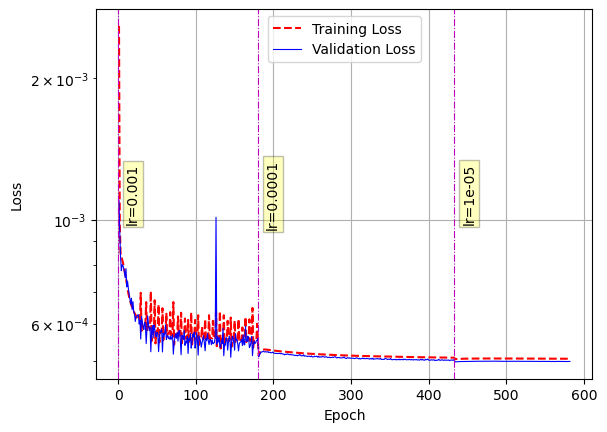

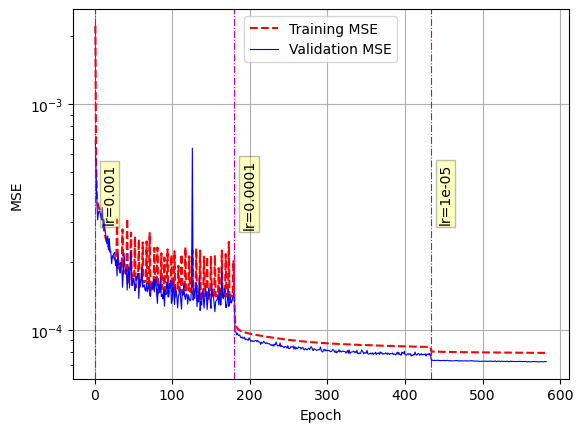

<Figure size 640x480 with 0 Axes>

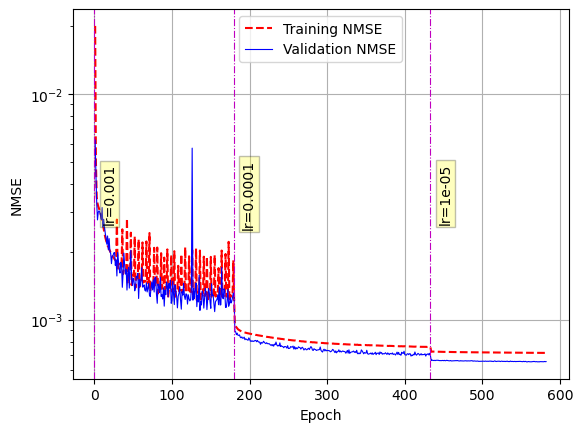

<Figure size 640x480 with 0 Axes>

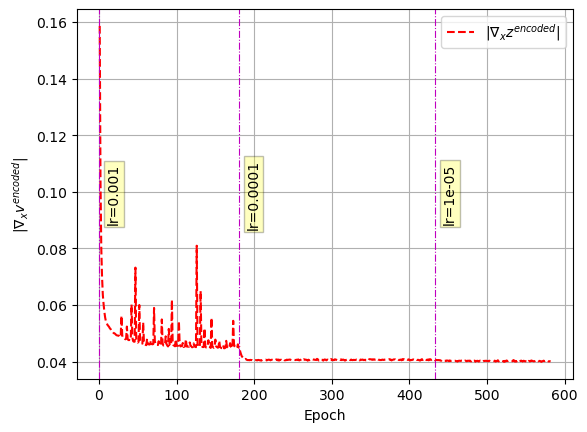

<Figure size 640x480 with 0 Axes>

In [29]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_ls_jacobian_norm_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\| \nabla_{x} z^{encoded} \|$"],
    xlabel='Epoch',
    ylabel=r"$\| \nabla_{x} v^{encoded} \|$",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_ls_jacobian_norm_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [30]:
reconstructed_data = ae_net.predict(all_data)

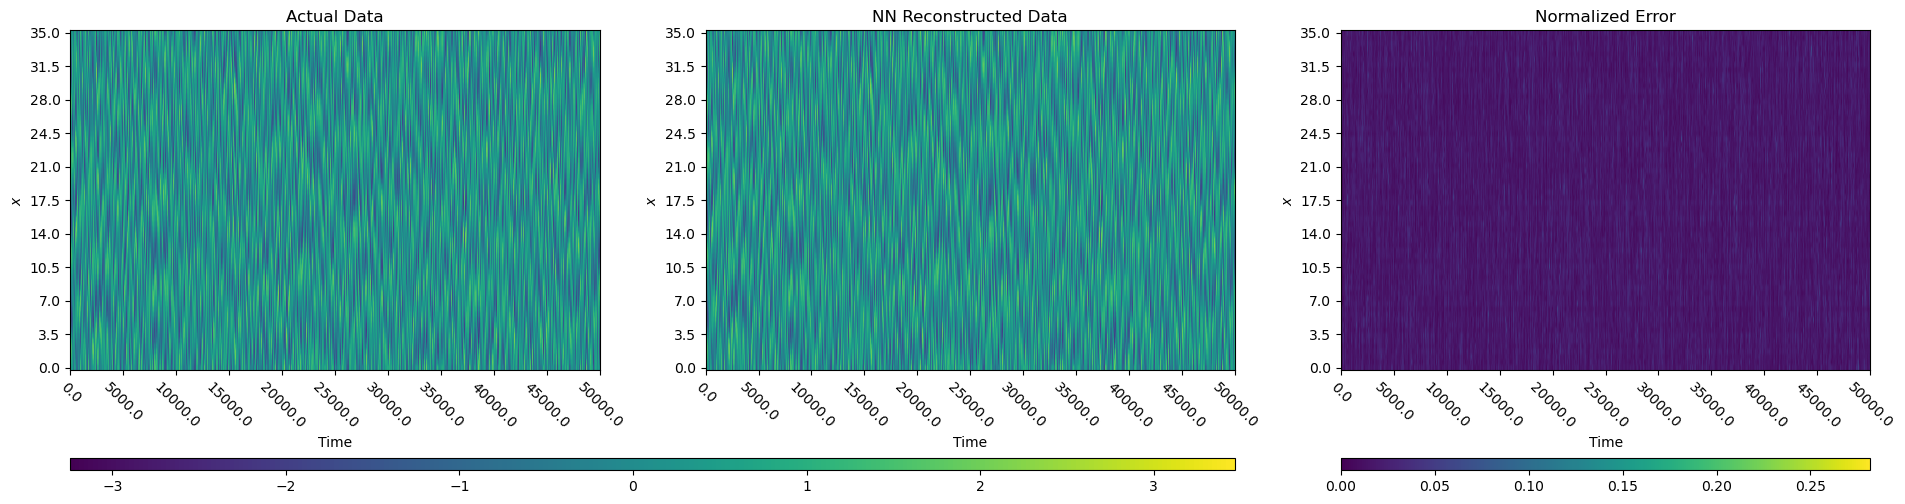

In [31]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [32]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [33]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

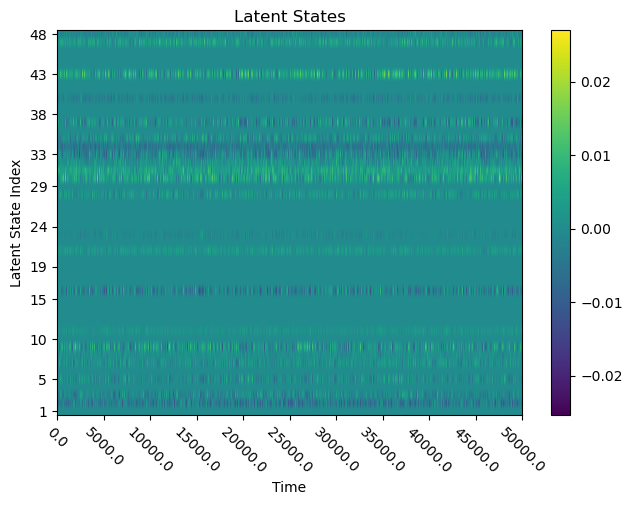

In [34]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

In [35]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [36]:
# ae_net.summary()

In [51]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 4
num_rows = (latent_states_all.shape[-1] + num_cols-1)//num_cols
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(num_rows, num_cols, sharex=False, figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    for j in range(latent_states_all.shape[-1]):
        row = j // num_cols
        col = j % num_cols
        ax[row, col].plot(input_time, latent_states_all[prev_idx:next_idx, j])
        # ax[j].plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
        # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
        # print(xticks)
        # ax[j].set_xticks(ticks=np.round(xticks*delta_t, 1))
        # ax[j].set_xticklabels('')
        ax[row, col].tick_params(axis='x', rotation=270+45)
        ax[row, col].set_ylabel('latent state {}'.format(j+1))
        ax[row, col].set_xlabel(r'Time$^+$')
        ax[row, col].grid(True)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    # ax[-1].set_xlabel(r'Time$^+$')
    # ax[0].legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    # ax.title.set_text(r'Case '+str(i+1))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Case '+str(i+1), size=16)
    
    fig.savefig(dir_name_plot+'/LatentSpace-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
    
    print('')

    prev_idx = boundary_idx_arr[i]

# KE and Dissipation

In [38]:
save_dir = dir_name_ae+dir_sep+'plots'
# save_dir = None

In [39]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr[i]

Case 1 - KE_nrmse : 0.009926288701035811


In [40]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [41]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [42]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr[i]

Case 1 - D_nrmse : 0.04056562860501069


In [43]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [44]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [45]:
# x = np.linspace(-5, 5, 100)

# a = 1 #- np.exp(-2)

# modified_relu = lambda x : tf.keras.activations.relu(x+a).numpy()-a
# elu = lambda x : tf.keras.activations.elu(x)

# y1 = modified_relu(x)
# y2 = elu(x)

# plt.plot(x, y1, label='modified_relu')
# plt.plot(x, y2, label='elu')
# plt.legend()
# plt.grid(True)
# plt.show()

In [46]:
ae_net.decoder_layers_list[-1].weights

[<tf.Variable 'dense_7/kernel:0' shape=(128, 64) dtype=float32, numpy=
 array([[-0.09068507, -0.09787045, -0.12881553, ..., -0.11898115,
         -0.11780627, -0.10608327],
        [-0.04417296, -0.07052863, -0.07009891, ...,  0.0284234 ,
          0.01201105, -0.01212398],
        [-0.06605139, -0.1076071 , -0.07865635, ...,  0.09332909,
          0.07412051,  0.01152426],
        ...,
        [ 0.00766781,  0.00160766,  0.02108964, ...,  0.05906839,
          0.05281889,  0.03068522],
        [ 0.00543162,  0.00401094, -0.00342032, ..., -0.04522264,
         -0.02699911, -0.00596068],
        [ 0.11654074,  0.03805257,  0.03397974, ...,  0.07990359,
          0.17743108,  0.19699004]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32, numpy=
 array([ 0.02081434,  0.02252822,  0.00016932, -0.02873984, -0.02681   ,
         0.00787131,  0.03531929,  0.03137041,  0.0128044 , -0.00825222,
        -0.02876038, -0.03342447, -0.00864976,  0.0217886 ,  0.02900585,
  